In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('./flist.csv')
df.rename(columns={'#key':'Name', 'created':'Created', 'size':'Size', 'mimetype':'Mimetype'}, inplace=True)
df.set_index('Name', inplace=True)
df.Created = pd.to_datetime(df.Created)

In [83]:
df.head()

,Created,Size,Mimetype,Cat
Name,,,,
SentiLex-PT02.zip,2017-10-22 16:50:22.413666,604242,application/zip,small
100LOS_cluster_random.zip,2017-10-13 14:02:02.354453,1329092,application/zip,moderate
50LOS_cluster_central.zip,2017-10-13 14:02:02.366603,1258126,application/zip,moderate
100LOS_cluster_random.zip,2017-10-13 13:29:03.207752,1447995,application/zip,moderate
50LOS_cluster_central.zip,2017-10-13 13:29:03.221556,1285703,application/zip,moderate


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2938 entries, SentiLex-PT02.zip to c33a933c-8202-11e3-92a1-005056943408.zip
Data columns (total 3 columns):
Created     2938 non-null datetime64[ns]
Size        2938 non-null int64
Mimetype    2938 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 91.8+ KB


In [5]:
# total size in GBs
df['Size'].sum()/(1024*1024*1024)

40.575949291698635

In [7]:
df.Size.describe()

count    2.938000e+03
mean     1.482917e+07
std      7.700631e+07
min      4.000000e+00
25%      1.100800e+04
50%      1.048576e+06
75%      1.421706e+06
max      1.570976e+09
Name: Size, dtype: float64

## Size analysis
Kafka is not the best solution for storing really large files. What should be the size limit

In [8]:
df['Cat'] = pd.cut(df.Size, bins=[0, 1024, 1024*1024, 40*1024*1024, 1.6e+09], 
              labels=['zeros', 'small', 'moderate', 'oversized'])

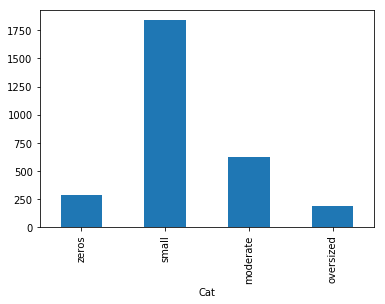

In [9]:
df.groupby('Cat')['Size'].count().plot(kind='bar')

In [89]:
import numpy as np
cs = np.log(df['Size'])
# we don't need file name anymore
cs = cs.reset_index()

In [90]:
cs.describe()

,Size
count,2938.000000
mean,12.397898
std,3.659881
min,1.386294
25%,9.306378
50%,13.862944
75%,14.167367
max,21.174963


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f9611d0>]], dtype=object)

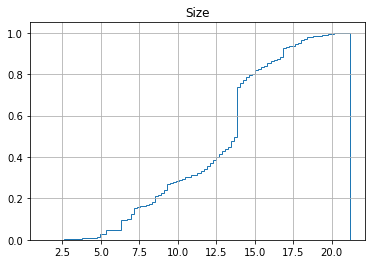

In [91]:
cs.hist(cumulative=True, normed=100, bins=100, histtype='step')

In [104]:
# if we take all up to val we will end up with more than 90%
val=17.5
size = np.exp(val)/(1024*1024)

percentage = 100*df.loc[df.Size < np.exp(val)].Size.count()/len(df)
print('Setting mark for size at {0:.2f} MB will still give us {1:.2f} % of data objects'.format(size, percentage))

Setting mark for size at 37.98 MB will still give us 93.53 % of data objects


# Service usage analysis

In [185]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

monthly = df.set_index('Created')

monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2938 entries, 2017-10-22 16:50:22.413666 to 2016-12-22 09:51:05.052595
Data columns (total 3 columns):
Size        2938 non-null int64
Mimetype    2938 non-null object
Cat         2938 non-null category
dtypes: category(1), int64(1), object(1)
memory usage: 71.9+ KB


In [207]:
obs = monthly.resample('M')['Size'].sum()
cts = monthly.resample('M')['Size'].count()

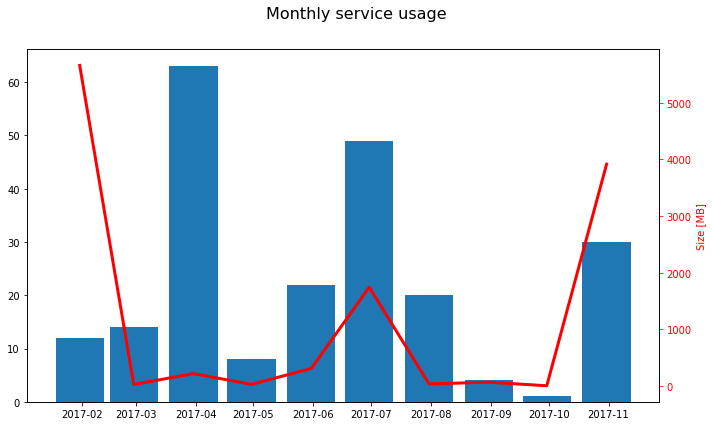

In [218]:
# skip the "migration" peak in the first month
res2 = obs.iloc[1:]
res = cts.iloc[1:]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(res.index, res, width=25)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.set_ylabel('Number of objects')


ax2 = ax.twinx()
ax2.plot(res2.index, res2/1000000, color='r', lw=3)
ax2.tick_params('y', colors='r')
ax2.set_ylabel('Size [MB]', color='r')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

fig.tight_layout()
fig.suptitle('Monthly service usage', fontsize=16)
fig.subplots_adjust(top=0.88)
